# Perceptrón multicapa

#### <div style="text-align: right"> Berenice Montalvo Lezama </div>

En este ejemplo veremos como implementar un perceptrón multicapa para la tarea de clasificación de imágenes. Emplearemos un conjunto referencia llamado [MNIST](http://yann.lecun.com/exdb/mnist/) recolectado por [Yann LeCun](http://yann.lecun.com). Tiene imágenes en escala de grises de 28 × 28 píxeles que contienen dígitos entre 0 y 9 escritos a mano. El conjunto cuenta con 60,000 imágenes de entrenamiento y 10,000 de prueba.

![Lecun](../figs/yan_lecun.png)


## 1 Carga de datos

Comenzaremos descargando y leyendo el conjunto de datos. Aprovecharemos que Tensorflow cuenta con utilerias en el paquete [`tf.keras.datasets`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/datasets) para descargar conjuntos de datos de referencia preprocesados.

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Model

tf.random.set_seed(2019)

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Una vez descargadas las imágenes, podemos visualizar algunas para ver cómo lucen.

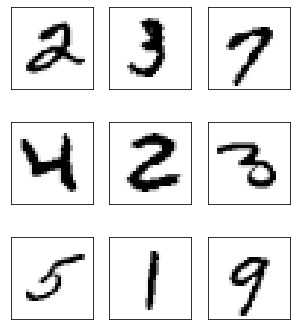

In [2]:
plt.figure(figsize=(5, 6))
for i in range(1, 10):
    plt.subplot(330 + i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[5 * i], cmap='Greys')

Ahora normalizamos las imágenes.

In [3]:
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train = y_train[..., tf.newaxis]
y_test = y_test[..., tf.newaxis]

Definimos nuestra tubería de datos para el conjunto de entrenamiento.

In [4]:
batch_size = 64
ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
ds = ds.shuffle(60000)
ds = ds.batch(batch_size)

for x, y_true in ds:
    print('x={} x.shape={}'.format(x.numpy().flatten(), x.shape))
    print('y={} y_true.shape={}'.format(y_true.numpy().flatten(), y_true.shape))
    break

W0826 21:17:36.833422 140385481750336 deprecation.py:323] From /home/richardt/.virtualenvs/riiaa/lib/python3.6/site-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


x=[0. 0. 0. ... 0. 0. 0.] x.shape=(64, 28, 28)
y=[2 6 0 7 8 7 5 7 7 4 4 4 3 2 3 7 7 6 3 7 0 3 1 3 1 6 1 3 1 0 6 4 9 9 4 0 5
 9 8 8 0 9 2 1 6 1 3 0 7 6 7 0 1 8 7 7 1 7 3 7 9 7 0 3] y_true.shape=(64, 1)


### Quiz 1

¿Cúal es la función de activación adecuada para la capa de salida de una red neuronal para clasificación multiclase?

## 2 Definición del modelo

In [5]:
class MLP(Model):

  def __init__(self):
    super(MLP, self).__init__()
    self.flatten = tf.keras.layers.Flatten()
    self.fc1 = Dense(128, activation=tf.nn.relu)
    self.fc2 = Dense(10, activation=tf.nn.softmax)

  def call(self, x):
    # (N, 28, 28) =>
    # (N, 28*28)
    o = self.flatten(x)
    # (N, 28*28) =>
    # (N, 128)
    o = self.fc1(o)
    # (N, 128) =>
    # (N, 10)
    o = self.fc2(o)
    return o

### Quiz 2

Si las clases fueran 100 en vez de 10 y quisera utilizar la misma arquitectura anterior ¿qué modificación tendría que realizar? 

### Definición de pérdida y optimizador

In [6]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

### Definición de métricas

Las clases dentro de `tf.keras.metrics` están diseñadas para mantener un histórico de una métrica a lo largo de los pasas de entrenamiento y agregarlo (con el promedio por ejemplo) para obtener el desempeño de la métrica a nivel epoca.

In [7]:
# historiales a nivel época
loss_epoch = tf.keras.metrics.SparseCategoricalCrossentropy()
acc_epoch = tf.keras.metrics.SparseCategoricalAccuracy()

# historiales a nivel entrenamiento
loss_history = []
acc_history = []

## 3 Entrenamiento

In [ ]:
model = MLP()

epochs = 25
for epoch in range(epochs):
    
    for x, y_true in ds:
        
        with tf.GradientTape() as tape:
            y_pred = model(x)
            loss = loss_fn(y_true, y_pred)            
        
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        loss_epoch(y_true, y_pred)
        acc_epoch(y_true, y_pred)
    
    loss_res = loss_epoch.result().numpy() * 100
    acc_res = acc_epoch.result().numpy() * 100
    loss_epoch.reset_states()
    acc_epoch.reset_states()
    
    loss_history.append(loss_res)
    acc_history.append(acc_res)

    print('E{:3d} loss={:6.2f}, acc={:6.2f}'.format(epoch, loss_res, acc_res))        

E  0 loss=194.70, acc= 44.45
E  1 loss=137.57, acc= 72.60
E  2 loss=102.29, acc= 79.43
E  3 loss= 82.57, acc= 82.48
E  4 loss= 70.85, acc= 84.18
E  5 loss= 63.23, acc= 85.27
E  6 loss= 57.89, acc= 86.06
E  7 loss= 53.94, acc= 86.73
E  8 loss= 50.89, acc= 87.23
E  9 loss= 48.46, acc= 87.65
E 10 loss= 46.47, acc= 87.99
E 11 loss= 44.81, acc= 88.33
E 12 loss= 43.40, acc= 88.58
E 13 loss= 42.18, acc= 88.82
E 14 loss= 41.11, acc= 89.04
E 15 loss= 40.16, acc= 89.22
E 16 loss= 39.32, acc= 89.36
E 17 loss= 38.56, acc= 89.54


Gráficamos la pérdida de nuestro modelo.

In [ ]:
plt.plot(np.arange(len(loss_history)), loss_history, color='red')
plt.xlabel('iteraciones')
plt.ylabel('entropía cruzada categorica')
plt.show()

Gráficamos la exactitud de nuestro modelo

In [ ]:
plt.plot(np.arange(len(acc_history)), acc_history, color='blue')
plt.xlabel('iteraciones')
plt.ylabel('exactitud')
plt.show()

## 4 Validación

In [ ]:
y_pred_test = model(x_test)
print(acc_epoch(y_test, y_pred_test).numpy() * 100)

In [ ]:
plt.figure(figsize=(5, 6))
for i in range(1, 10):
    plt.subplot(330 + i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[5*i], cmap='Greys')
    plt.title(y_pred_test[5*i].numpy().argmax())